<script src="https://polyfill.io/v3/polyfill.min.js?features=es6"></script> 
<script id="MathJax-script" async src="https://cdn.jsdelivr.net/npm/mathjax@3.0.1/es5/tex-mml-chtml.js"></script>

# Figure S6: Analysis of Whole Genome Sequencing

Code by Joshua W. McCausland in Christine Jacobs-Wagner's lab, 2025. Irnov Irnov contributed one function, noted in preamble, and original logic for counting reads in specified base pair windows in the genome.

I sent 3 gDNA replicates each of 4 wild type strains to SeqCenter for whole genome sequencing. All were harvested at $1*10^7$ cells/ml.
- 3x strain 297
- 3x strain B31-K2 (K2 here)
- 3x strain B31-IR (B31 here). Replicate 2 didn't have enough gDNA, so I grabbed the results of an exponential phase gDNA experiment from Irnov. That was used to assess plasmid content in [Takacs et al. (2022)](https://www.nature.com/articles/s41467-022-34876-4), but wasn't plotted for the paper. It is called Replicate 4 here.
- 3x strain N40. 

All raw fastq.gz sequence files were aligned to reference genomes using [Breseq](https://github.com/barricklab/breseq/wiki). 
- Strain 297. [Genome assembly ASM4079079v1](https://www.ncbi.nlm.nih.gov/datasets/genome/GCF_040790795.1/), assembled from [Tatusova et al. 2014](https://pubmed.ncbi.nlm.nih.gov/24316578/) and based on sequences from [Casjens et al. 2011](https://pubmed.ncbi.nlm.nih.gov/20935092/).
  - I added an additional five cp32 plasmids to this assembly. [Casjens et al. 2012](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0033280) deposited additional sequences for these 5 plasmids: cp31-1, cp32-5, cp32-6, cp32-9, cp31-12.
- Strain N40. [Genome assembly ASM16663v1](https://www.ncbi.nlm.nih.gov/datasets/genome/GCF_000166635.1/), based on sequences from [Casjens et al. 2012](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0033280).
- Strains B31 and K2. [Genome assembly ASM868v2](https://www.ncbi.nlm.nih.gov/datasets/genome/GCF_000008685.2/), based on original B31-MI whole genome sequences from [Fraser et al. 1997](https://pubmed.ncbi.nlm.nih.gov/9403685/).

In [1]:
import glob,os
import HTSeq
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import statistics
plt.rcParams["font.family"] = "Arial" #Set global font to arial
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from time import time
from Bio import GenBank
import re

basepair_window_size = 4000
normalization_constant = 1000000
minimum_normalized_value_y = 0
maximum_normalized_value_y = 250
max_size_for_consideration_bp_from_chr_end = 500
MASK_SIZE=500           #bp to ignore for either ends of the chromosome

"""
FUNCTION: get_center_and_count
Author: Irnov Irnov
get the center position and total read count for each chromosome region (ie. WINDOW)
index is a list containing the lower boundary value (or left boundary) for each 'window'
MASK_SIZE and WINDOW_SIZE are constant value
'center_pos' will contain the center position for each DNA window
'counts' will contain the median number of counts for that window
"""
def get_center_and_count (left_bound_list, count_list, bp_to_mask, size_of_window, size):

    #variables to hold the center position and counts for each window
    center_pos = []
    counts = []
    
    #loop through the window using the index above
    for j in left_bound_list:
        
        #set the starting position for each window
        #IF at the beginning, mask the beginning of the genome due to low coverage (do not count)
        #set mask size in MASK_SIZE constant variable
        start = j
        if start == 0: start = bp_to_mask-1
         
        #set the end position for each window
        #IF at the end, mask the end of the genome due to low coverage (do not count)
        #set mask size in MASK_SIZE constant variable
        end = j + size_of_window
        if end > size: end = size - bp_to_mask

        #get the median read count for each window
        #if the window is too small (eg. near the end), ignore it
        if (end-start > bp_to_mask/2):
            center_pos.append((j + (size_of_window/2)))
            counts.append(statistics.median(count_list[start:end]))
    
    return center_pos, counts

This first chunk takes a *long* time to run. It will go through every single BAM file and look at every alignment, tallying 1 for every alignment in the BAM file. 
- This creates HTSeq objects. These objects cannot be saved, and so they will be present in RAM until you are done with the process. 
- This only works on Linux or Mac. 

In [ ]:
experiment_directory = '/Volumes/Data_05/Shares/Data_05/Josh_McCausland/Projects/Bb_PG_Shedding/plasmid_verification'
filelist = glob.glob(f'{experiment_directory}/bam_files/*.bam')
cvg_list = {}
aln_count_list = {}

for file in filelist:
    filename = os.path.basename(file).removesuffix('.bam')
    print(f'Currently parsing {filename}.')
    t1 = time()
    bam_reader = HTSeq.BAM_Reader(file)
    # Use the HTSeq GenomicArray to get aligned reads and counts
    aln_count = 0
    cvg = HTSeq.GenomicArray( "auto", stranded=False, typecode='i' )
    for aln in bam_reader:
        if aln.aligned:
            cvg[aln.iv] += 1
            aln_count += 1
    
    cvg_list.update({filename: cvg})
    aln_count_list.update({filename: aln_count})
    total_time = time() - t1
    print(f'{filename} took {total_time/60:.2f} min.')

Currently parsing K2_1.
K2_1 took 1.91 min.
Currently parsing K2_3.
K2_3 took 2.16 min.
Currently parsing K2_2.
K2_2 took 2.01 min.
Currently parsing 297_1.
297_1 took 1.84 min.
Currently parsing N40_1.
N40_1 took 1.80 min.
Currently parsing N40_3.
N40_3 took 2.00 min.
Currently parsing 297_2.
297_2 took 2.21 min.
Currently parsing 297_3.
297_3 took 2.18 min.
Currently parsing N40_2.
N40_2 took 2.04 min.
Currently parsing B31_3.
B31_3 took 4.39 min.
Currently parsing B31_1.
B31_1 took 4.54 min.
Currently parsing B31_4.
B31_4 took 42.56 min.


Now use the coverage and alignment data to count the aligned reads for each genetic element. 
- First create a "strain_data" dataframe. I use each whole genome file (genbank format, saved as ".gbff"). 
- Strain_data has every genetic element, its source organism, and the element size. All elements from all organisms are concatenated in one dataframe. 
- Then iterate through each genetic element. For every sample, count the coverage for that element. Of course, B31 samples will have 0 coverage for 297 elements for example. 
- Final dataframe (normalized counts for each element) is saved as "quantified_element_counts" in both xlsx and pkl formats.
- A coverage dataframe is also saved in pkl format. 

In [ ]:
num_of_data = cvg_list.__len__()
cmap = matplotlib.cm.get_cmap('tab10',num_of_data).colors

pooled_count_df = pd.DataFrame()
copy_num_df = pd.DataFrame()
strain_data = pd.DataFrame()

# Create a dataframe with each strain's genetic elements, their sizes, and accession numbers.
# Identify the source Genbank files.
genome_files = glob.glob('genome_reference_files/*.gbff')
strains = ['297','N40','B31','K2']
for strain in strains:
    file_curr = list(filter(lambda x: strain in x, genome_files))[0]
    with open(file_curr) as handle:
        idx = 0
        for record in GenBank.parse(handle):

            # pull out the common name for each Borrelia plasmid.
            if 'plasmid' in record.definition:
                find_plasmid_index_start = re.search(r'plasmid ',record.definition)
                find_plasmid_index_end = re.search(r', ',record.definition)
                element = record.definition[find_plasmid_index_start.span()[1]:find_plasmid_index_end.span()[0]]
            else:
                element = 'chromosome'     

            # add to the strain dataframe the genetic element, it size, and its source strain.   
            temp_df = pd.DataFrame({
                'accession': record.accession[0],
                'element_size': int(record.size),
                'genbank_source': strain,
                'element': element,
                'strain': strain
            },index=[idx])
            idx += 1
            strain_data = pd.concat([strain_data,temp_df],axis=0)
        strain_data = strain_data.sort_values(by='element_size',ascending=False)

# Iterate through the pooled strain elements and count aligned reads for each element in every strain.
_idx = 0
for _,row in strain_data.iterrows():
    start = max_size_for_consideration_bp_from_chr_end
    end = row.element_size-max_size_for_consideration_bp_from_chr_end

    # Every coverage object for all samples will be iterated here to calculate coverage and relative copy number.
    for key,cvg in cvg_list.items():

        # pull the alignment counts for the current coverage object.
        aln_count = aln_count_list[key]

        # use HTSeq to get the alignments for the specified start and end for the current accession number.
        count_array = list(cvg[HTSeq.GenomicInterval(row.accession,0,row.element_size,'.')])
        count_array_for_copy_number = list(cvg[ HTSeq.GenomicInterval(row.accession,start,end,'.' )])

        # Create an index for the rolling window (4000bp in my case), even steps from 0 to the max element size.
        index = np.arange(0, row.element_size, basepair_window_size).tolist()

        # Like a histogram, get the counts in each index. 
        center_pos, counts = get_center_and_count(index, count_array, max_size_for_consideration_bp_from_chr_end, basepair_window_size,row.element_size)

        # Normalize the counts for each window, or the overall genetic element.
        counts = np.array(counts) / aln_count*normalization_constant
        rel_number = statistics.median(count_array)
        rel_number = rel_number / aln_count*normalization_constant

        # This is for a 4000bp coverage window for each genetic element.
        temp_df = pd.DataFrame({
            'chr': np.repeat(row.element,len(center_pos)),
            'accession': np.repeat(row.accession,len(center_pos)),
            'genbank_source': np.repeat(row.genbank_source,len(center_pos)),
            'condition': np.repeat(key,len(center_pos)),
            'center_pos': center_pos,
            'counts': counts
        })

        # This is for creating a dataframe for relative copy number for each genetic element. 
        temp_count_df = pd.DataFrame({
            'chr': row.element,
            'accession': row.accession,
            'genbank_source': row.genbank_source,
            'element_size': row.element_size,
            'condition': key,
            'normalized_counts': rel_number  
        },index=[_idx])
        _idx += 1

        # Add all measurements to the final dataframes.
        pooled_count_df = pd.concat([pooled_count_df,temp_df],axis=0)
        copy_num_df = pd.concat([copy_num_df,temp_count_df],axis=0)

pooled_count_df['strain'] = pooled_count_df.condition.apply(lambda x: x.split('_')[0])
pooled_count_df['replicate'] = pooled_count_df.condition.apply(lambda x: x.split('_')[1])

copy_num_df['strain'] = copy_num_df.condition.apply(lambda x: x.split('_')[0])
copy_num_df['replicate'] = copy_num_df.condition.apply(lambda x: x.split('_')[1])

print('The coverage dataframe for all samples.')
display(pooled_count_df.head(5))
pooled_count_df.to_pickle('counts_per_4000bp_window.pkl')

print('The relative copy number dataframe for all samples.')
display(copy_num_df.head(5))
copy_num_df.to_excel('quantified_element_counts.xlsx') #This is for Github upload later.
copy_num_df.to_pickle('quantified_element_counts.pkl')

The coverage dataframe for all samples.


,chr,accession,genbank_source,condition,center_pos,counts,strain,replicate
0,chromosome,NZ_CP161158,297,K2_1,2000.0,0.0,K2,1
1,chromosome,NZ_CP161158,297,K2_1,6000.0,0.0,K2,1
2,chromosome,NZ_CP161158,297,K2_1,10000.0,0.0,K2,1
3,chromosome,NZ_CP161158,297,K2_1,14000.0,0.0,K2,1
4,chromosome,NZ_CP161158,297,K2_1,18000.0,0.0,K2,1


The relative copy number dataframe for all samples.


,chr,accession,genbank_source,element_size,condition,normalized_counts,strain,replicate
0,chromosome,NZ_CP161158,297,916773,K2_1,0.000000,K2,1
1,chromosome,NZ_CP161158,297,916773,K2_3,0.000000,K2,3
2,chromosome,NZ_CP161158,297,916773,K2_2,0.000000,K2,2
3,chromosome,NZ_CP161158,297,916773,297_1,83.683679,297,1
4,chromosome,NZ_CP161158,297,916773,N40_1,0.000000,N40,1


This is a test to make sure the reads look roughly correct. It plots the number of reads per 4000 bp window (I counted reads per 4000 bp window above).

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


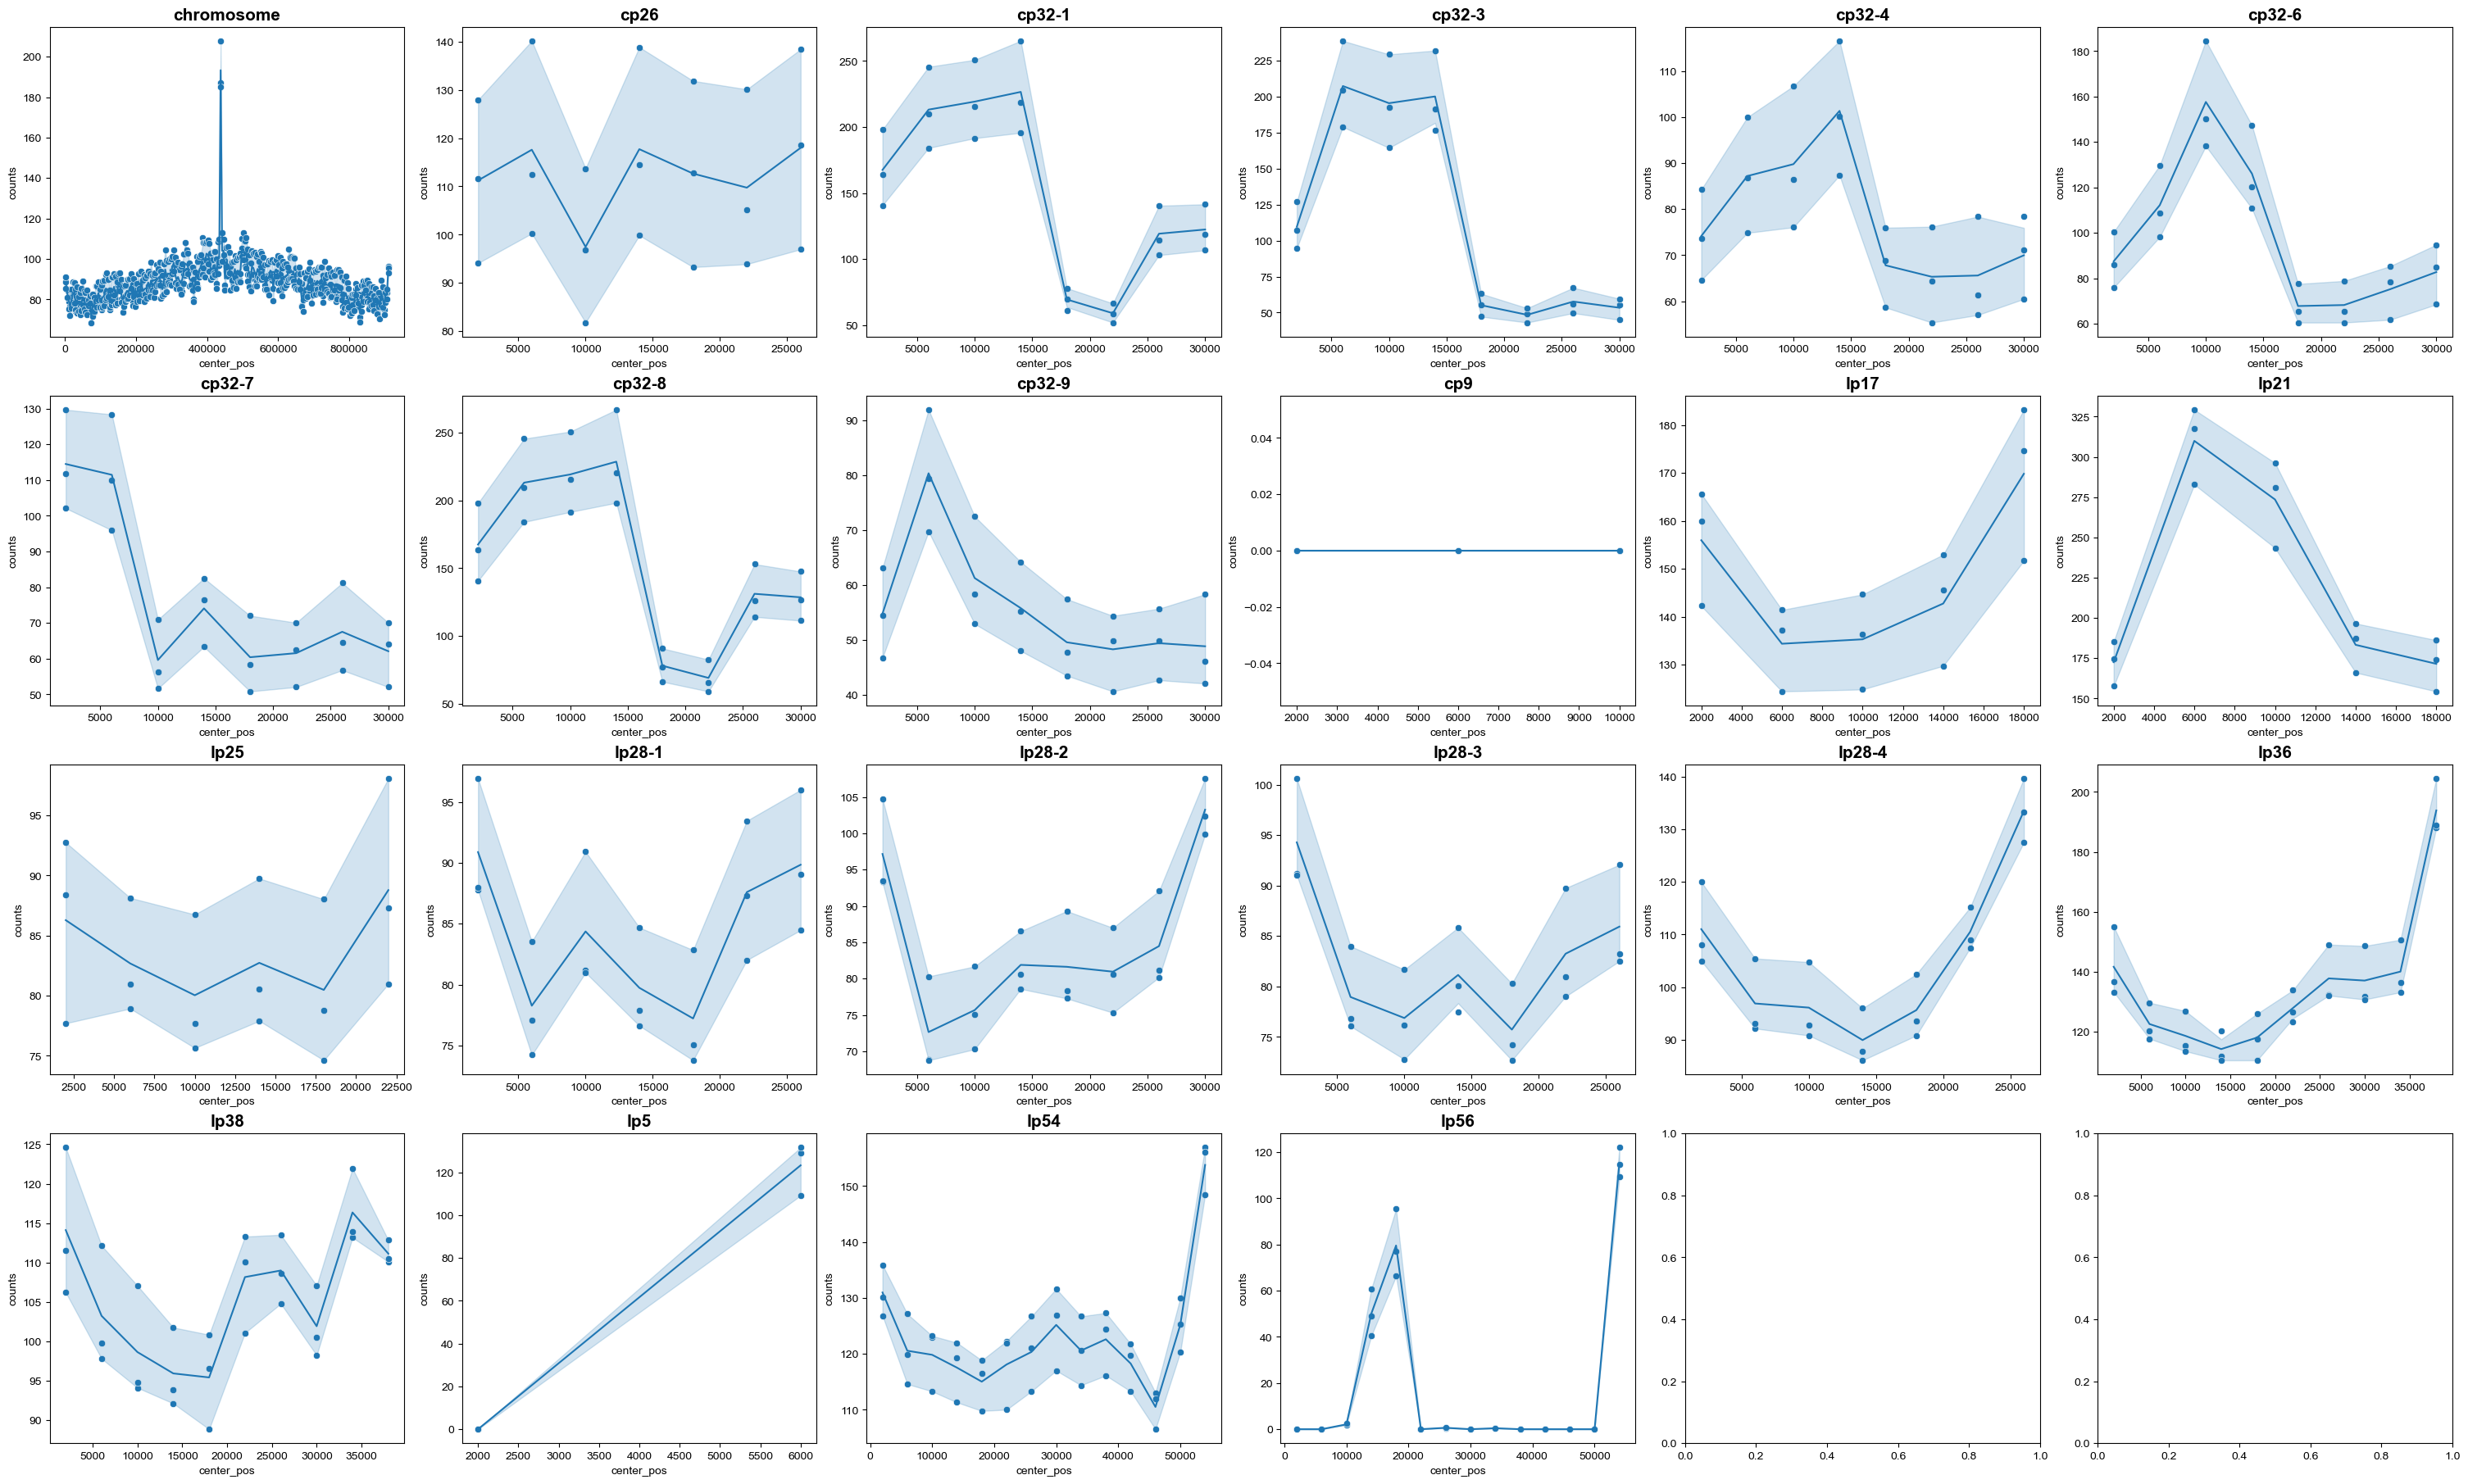

In [ ]:
element_to_plot = 'chromosome'
_strain = 'K2'
df = pd.read_pickle('included_small_datasets/counts_per_4000bp_window.pkl')
df = df[(df.strain == _strain) & (df.genbank_source == _strain)]

fig,axs = plt.subplots(nrows = 4, ncols = 6,figsize=[30,18],layout='constrained')
for grouped,_ax in zip(df.groupby('chr'),axs.ravel()):
    element_to_plot = grouped[0]
    grp = grouped[1]
    if element_to_plot != 'chromosome':
        sns.scatterplot(data=grp,x='center_pos',y='counts',ax=_ax,legend=False)
    else:
        sns.scatterplot(data=grp,x='center_pos',y='counts',ax=_ax)
    sns.lineplot(data=grp,x='center_pos',y='counts',ax=_ax,legend=False)
    _ax.set_title(element_to_plot,fontsize=15,weight='bold')

axs[0,0].legend(frameon=False,fontsize=15,loc='upper left')
plt.savefig(f'plots/read_counts_{_strain}.pdf')

Plot the normalized copy number of each genetic element to the chromosome. 
- Elements with close to or around 0 counts do not have the element of choice.
- Strain 297 lacks cp32-6 and cp32-9. It's not the "ideal" wild type since it lacks these plasmids, but at least its infectivity shouldn't be impacted (see [Wachter et al. 2025](https://pubmed.ncbi.nlm.nih.gov/40108404/)).
- Strain B31-IR lacks cp9 and lp5, as expected.
- Strain B31-K2 lacks lp56, cp9 and lp5, as expected.
- Strain N40 lacks cp9. This is fine since B31 also lacks that plasmid.

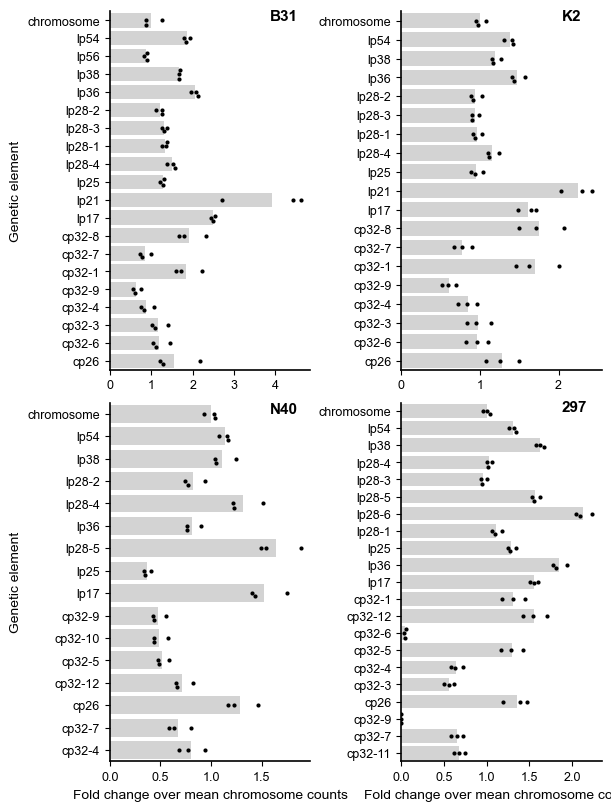

In [ ]:
df = pd.read_pickle('included_small_datasets/quantified_element_counts.pkl')
df['state'] = np.repeat('z',df.shape[0])
df['state'] = df.apply(lambda row: row.state if row.chr == 'chromosome' else 'circular',axis=1)
df['state'] = df.apply(lambda row: 'linear' if 'lp' in row.chr else row.state,axis=1)

''' 
We already know that the wild type strains lack lp5 and cp9. 
    - We also know that K2 alreayd lacks lp56.
    - You can see in these data that these strains lack those expected plasmids.
    - For this figure, plot what plasmids we *would* expect to be present. Any absent from there show deviation.
'''
plasmids_to_drop = {
    'B31': ['lp5','cp9'],
    'K2': ['lp5','cp9','lp56'],
    'N40': ['N40_lp5','N40_cp9'],
    '297': ['lp5','cp9']
}
strain_order = ['B31','K2','N40','297']

fig,axs = plt.subplots(nrows = 2, ncols = 2,layout='constrained',figsize=[6,8])
for _ax,_strain in zip(axs.ravel(),strain_order):
    grp = df[(df.strain == _strain) & (df.genbank_source == _strain)]
    grp = grp.sort_values(by=['state','element_size'],ascending=False)
    grp = grp.drop(grp[grp.chr.isin(plasmids_to_drop[_strain])].index,axis=0)
    grp['chr'] = grp.chr.apply(lambda x: x.split('_')[-1] if x != 'chromosome' else x)
    chr_ave = grp[(grp.chr =="chromosome")]["normalized_counts"].mean()
    grp['normalized_counts'] = grp.normalized_counts.apply(lambda x: x/chr_ave)
    sns.barplot(data=grp,y='chr',x='normalized_counts',ax=_ax,orient='h',color='lightgray',errorbar=None)
    sns.swarmplot(data=grp,y='chr',x='normalized_counts',ax=_ax,orient='h',color='black',size=3,legend=False)
    _ax.set_ylabel('')
    _ax.set_xlabel('')
    _ax.tick_params(axis='both',labelsize=9)
    _ax.spines[['right','top']].set_visible(False)
    _ax.spines[['left','bottom']].set_linewidth(1.2)
    xlimits = _ax.get_xlim()
    xscale = xlimits[1] - (xlimits[1] - xlimits[0])/5
    ylimits = _ax.get_ylim()
    yscale = ylimits[1] - (ylimits[1] - ylimits[0])/5
    _ax.text(xscale,0,_strain,fontsize=11,fontweight='bold')

    if _strain in ['N40','297']:
        _ax.set_xlabel('Fold change over mean chromosome counts')
    if _strain in ['B31','N40']:
        _ax.set_ylabel('Genetic element')